In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Core
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Settings
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
# 1. Transformer to extract temporal features from 'Date'
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['Date'] = pd.to_datetime(X['Date'])
        X['Year'] = X['Date'].dt.year
        X['Month'] = X['Date'].dt.month
        X['DayOfWeek'] = X['Date'].dt.dayofweek
        return X.drop('Date', axis=1)

# 2. Transformer to encode teams based on their historical points performance
class TeamStrengthEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.team_stats_map = {}
        self.global_mean = 0

    def fit(self, X, y):
        # We calculate the average "strength" per team using the target proxy
        temp_df = pd.DataFrame({
            'team': pd.concat([X[self.cols[0]], X[self.cols[1]]]), 
            'points': np.tile(y, 2)
        })
        self.team_stats_map = temp_df.groupby('team')['points'].mean().to_dict()
        self.global_mean = temp_df['points'].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            X[col] = X[col].map(self.team_stats_map).fillna(self.global_mean)
        return X

In [24]:
def process_ml_data_optimized(file_paths):
    all_training_data = []

    for file in file_paths:
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
        df = df.sort_values('Date')

        teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
        stats = {t: {'MP': 0, 'Pts': 0, 'Gls': 0, 'GA': 0, 'H_MP': 0, 'H_Pts': 0, 'A_MP': 0, 'A_Pts': 0} for t in teams}

        for _, row in df.iterrows():
            ht, at = row['HomeTeam'], row['AwayTeam']
            
            # Dynamic Ranking logic
            sorted_table = sorted(stats.items(), 
                                 key=lambda x: (x[1]['Pts'], x[1]['Gls'] - x[1]['GA'], x[1]['Gls']), 
                                 reverse=True)
            ranks = {team_name: rank + 1 for rank, (team_name, _) in enumerate(sorted_table)}

            h_s, a_s = stats[ht], stats[at]
            
            if h_s['MP'] >= 3 and a_s['MP'] >= 3:
                all_training_data.append({
                    'Date': row['Date'], 'HomeTeam': ht, 'AwayTeam': at, 'Result': row['FTR'],
                    'Home_Rk': ranks[ht], 'Home_Pts_MP': h_s['Pts']/h_s['MP'], 'Home_GD': h_s['Gls']-h_s['GA'],
                    'Home_H_Pts_MP': h_s['H_Pts']/h_s['H_MP'] if h_s['H_MP'] > 0 else 0,
                    'Home_Gls': h_s['Gls'], 'Home_GA': h_s['GA'],
                    'Away_Rk': ranks[at], 'Away_Pts_MP': a_s['Pts']/a_s['MP'], 'Away_GD': a_s['Gls']-a_s['GA'],
                    'Away_A_Pts_MP': a_s['A_Pts']/a_s['A_MP'] if a_s['A_MP'] > 0 else 0,
                    'Away_Gls': a_s['Gls'], 'Away_GA': a_s['GA']
                })

            h_p = 3 if row['FTR'] == 'H' else (1 if row['FTR'] == 'D' else 0)
            a_p = 3 if row['FTR'] == 'A' else (1 if row['FTR'] == 'D' else 0)
            
            stats[ht].update({'MP': h_s['MP']+1, 'Pts': h_s['Pts']+h_p, 'Gls': h_s['Gls']+row['FTHG'], 'GA': h_s['GA']+row['FTAG'], 'H_MP': h_s['H_MP']+1, 'H_Pts': h_s['H_Pts']+h_p})
            stats[at].update({'MP': a_s['MP']+1, 'Pts': a_s['Pts']+a_p, 'Gls': a_s['Gls']+row['FTAG'], 'GA': a_s['GA']+row['FTHG'], 'A_MP': a_s['A_MP']+1, 'A_Pts': a_s['A_Pts']+a_p})

    return pd.DataFrame(all_training_data)

In [25]:
# 1. Load Data
train_df = pd.read_csv('train.csv')

# 2. Setup Targets
y = train_df['Result'].map({'H': 0, 'D': 1, 'A': 2})
X = train_df.drop('Result', axis=1)

# 3. Define the Base Pipeline
base_pipeline = Pipeline([
    ('date_features', DateFeatureExtractor()),
    ('team_strength', TeamStrengthEncoder(cols=['HomeTeam', 'AwayTeam'])),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 4. Define Bayesian Search Space
# Note the 'classifier__' prefix to target the estimator parameters
search_space = {
    'classifier__n_estimators': Integer(100, 500),
    'classifier__max_depth': Integer(5, 20),
    'classifier__min_samples_leaf': Integer(5, 30),
    'classifier__max_features': Categorical(['sqrt', 'log2', None])
}

# 5. Initialize BayesSearchCV
opt = BayesSearchCV(
    base_pipeline,
    search_space,
    n_iter=32,            # Number of iterations
    cv=3,                 # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,            # Use all available cores
    random_state=42,
    verbose=1
)

# 6. Time-based split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 7. Execute Optimization
print("Starting Bayesian Optimization...")
opt.fit(X_train, y_train)

# 8. Extract the best model
pipeline = opt.best_estimator_
print("\nOptimization Complete.")
print(f"Best Parameters: {opt.best_params_}")
print(f"Best CV Accuracy: {opt.best_score_:.2%}")

Starting Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for ea

--- TRAINING SET METRICS (OPTIMIZED) ---
Accuracy: 55.21%

Classification Report:
              precision    recall  f1-score   support

    Home Win       0.55      0.87      0.68       457
        Draw       0.62      0.06      0.11       258
    Away Win       0.54      0.49      0.51       274

    accuracy                           0.55       989
   macro avg       0.57      0.47      0.43       989
weighted avg       0.57      0.55      0.48       989



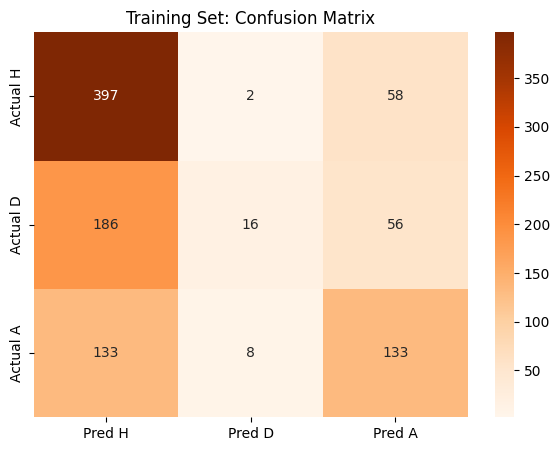

In [26]:
# Predict on training set
y_train_pred = pipeline.predict(X_train)

print("--- TRAINING SET METRICS (OPTIMIZED) ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Home Win', 'Draw', 'Away Win']))

# Confusion Matrix for Training Set
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Pred H', 'Pred D', 'Pred A'], yticklabels=['Actual H', 'Actual D', 'Actual A'])
plt.title('Training Set: Confusion Matrix')
plt.show()

--- TEST SET METRICS (OPTIMIZED) ---
Accuracy: 56.45%

Classification Report:
              precision    recall  f1-score   support

    Home Win       0.59      0.87      0.70       121
        Draw       0.40      0.07      0.12        56
    Away Win       0.53      0.44      0.48        71

    accuracy                           0.56       248
   macro avg       0.50      0.46      0.43       248
weighted avg       0.53      0.56      0.51       248



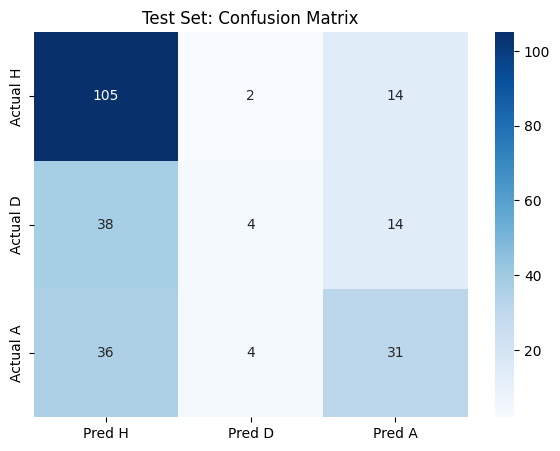


--- Random Test Samples (N=15) ---


,Date,Home Team,Away Team,Actual,Predicted,Confidence
0,2025-12-06,Betis,Barcelona,A,A,45.9%
1,2025-11-01,Ath Madrid,Sevilla,H,H,67.0%
2,2025-12-03,Ath Bilbao,Real Madrid,A,A,51.2%
3,2025-12-08,Osasuna,Levante,H,H,44.6%
4,2025-05-11,Betis,Osasuna,D,H,44.4%
5,2025-05-25,Ath Bilbao,Barcelona,A,H,49.4%
6,2025-12-13,Ath Madrid,Valencia,H,H,76.6%
7,2025-10-27,Betis,Ath Madrid,A,H,43.3%
8,2025-11-30,Sociedad,Villarreal,A,A,51.5%
9,2025-10-05,Sociedad,Vallecano,A,H,43.7%


In [27]:
# 1. Predict on test set
y_test_pred = pipeline.predict(X_test)
y_test_probs = pipeline.predict_proba(X_test)

print("--- TEST SET METRICS (OPTIMIZED) ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Home Win', 'Draw', 'Away Win']))

# 2. Confusion Matrix for Test Set
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred H', 'Pred D', 'Pred A'], yticklabels=['Actual H', 'Actual D', 'Actual A'])
plt.title('Test Set: Confusion Matrix')
plt.show()

# 3. 15 Random Test Samples
label_map = {0: 'H', 1: 'D', 2: 'A'}
test_indices = np.random.choice(X_test.index, 15, replace=False)

samples_list = []
for idx in test_indices:
    pos = list(X_test.index).index(idx)
    samples_list.append({
        'Date': X_test.loc[idx, 'Date'],
        'Home Team': train_df.loc[idx, 'HomeTeam'],
        'Away Team': train_df.loc[idx, 'AwayTeam'],
        'Actual': label_map[y_test.loc[idx]],
        'Predicted': label_map[y_test_pred[pos]],
        'Confidence': f"{np.max(y_test_probs[pos]):.1%}"
    })

print("\n--- Random Test Samples (N=15) ---")
display(pd.DataFrame(samples_list))